In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [374]:
source = 'pecan_street'
place = 'new_york'
interval = '15minute'

# Pecan Street Data

In [375]:
data_newyork_15min = pd.read_csv('../Dataset/' + source + '/' + place + '/' + interval + '.csv')

In [376]:
sorted_value = data_newyork_15min.sort_values(by=['dataid', 'local_15min'])

In [377]:
sorted_value[['car1', 'car2']].replace(np.nan, 0, inplace=True)

C:\Users\Belal Mahmud Fahim\AppData\Local\Temp\ipykernel_6840\876318672.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_value[['car1', 'car2']].replace(np.nan, 0, inplace=True)


In [378]:
dataid_with_ev_list = sorted_value[(sorted_value['car1'] > 0) | (sorted_value['car2'] > 0)]['dataid'].unique()

In [379]:
dataid_with_ev_list

array([  27, 1222, 3000, 5679, 9053], dtype=int64)

In [186]:
meta_data = pd.read_csv('../Dataset/' + source + '/' + place + '/metadata.csv')

In [187]:
dataid_with_availability = meta_data[(meta_data['egauge_1min_data_availability'] == '100%') | (meta_data['egauge_1min_data_availability'] == '99%')]['dataid'].unique()

In [188]:
dataid_with_availability = [int(x) for x in dataid_with_availability]

In [189]:
dataid_with_ev_list = np.intersect1d(dataid_with_ev_list, dataid_with_availability)

In [366]:
house_type = meta_data[1:][meta_data[1:]['dataid'].astype(int).isin(dataid_with_ev_list)][['dataid', 'building_type']]

In [367]:
house_type

,dataid,building_type
92,661,Single-Family Home 001 (Master)
94,1642,Single-Family Home 001 (Master)
97,2335,Single-Family Home 001 (Master)
294,4373,Single-Family Home 001 (Master)
308,8156,Single-Family Home 001 (Master)
1410,4767,Single-Family Home 001 (Master)
1638,6139,Single-Family Home 001 (Master)
1675,9278,Single-Family Home 001 (Master)
1725,7719,Single-Family Home 001 (Master)


In [368]:
for i in dataid_with_ev_list:
    house_wise_data = sorted_value[sorted_value['dataid'] == i]
    house_wise_data.replace(np.nan, 0, inplace=True)
    house_wise_data['total_power_consumption'] = house_wise_data['grid'] + house_wise_data['solar'] + house_wise_data['solar2']
    house_wise_data['local_15min'] = pd.to_datetime(house_wise_data['local_15min'])
    fixed_columns = ['local_15min']
    house_hold_columns = [col for col in house_wise_data.columns if col not in fixed_columns]

    if house_wise_data[house_wise_data['total_power_consumption'] < 0].shape[0] > 0:
        house_wise_data.set_index('local_15min', inplace=True)
        copy_dataset = house_wise_data.copy()
        indexes = house_wise_data[house_wise_data['total_power_consumption'] < 0].index
        for j in indexes:
            prev_data = copy_dataset.loc[j - pd.Timedelta(weeks=1)]
            house_wise_data.loc[j, house_hold_columns] = prev_data[house_hold_columns]
        house_wise_data.reset_index(inplace=True)

    house_wise_data['house_type'] = house_type[house_type['dataid'].astype(int) == i]['building_type'].to_string(index=False).strip()
    house_wise_data.to_csv('../Dataset/' + source + '/' + place + '/house_energy/' + str(i) + '.csv', index=False)

    fixed_columns = ['dataid', 'local_15min', 'house_type', 'solar', 'solar2', 'leg1v', 'leg2v', 'total_power_consumption', 'grid']
    house_hold_columns = [col for col in house_wise_data.columns if col not in fixed_columns]
    house_wise_data[house_hold_columns] = house_wise_data[house_hold_columns].abs()
    house_wise_data['total_usage'] = house_wise_data[house_hold_columns].sum(axis=1)
    house_wise_data['ev_car'] = house_wise_data['car1'] + house_wise_data['car2']
    house_wise_data['solar'] = house_wise_data['solar'] + house_wise_data['solar2']
    final_dataset = house_wise_data[['dataid', 'local_15min', 'house_type', 'ev_car', 'solar', 'grid', 'total_power_consumption', 'total_usage']]
    final_dataset.to_csv('../Dataset/' + source + '/' + place + '/house_energy_compressed/' + str(i) + '_compressed.csv', index=False)

C:\Users\Belal Mahmud Fahim\AppData\Local\Temp\ipykernel_6840\1187340200.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_wise_data.replace(np.nan, 0, inplace=True)
C:\Users\Belal Mahmud Fahim\AppData\Local\Temp\ipykernel_6840\1187340200.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_wise_data['total_power_consumption'] = house_wise_data['grid'] + house_wise_data['solar'] + house_wise_data['solar2']
C:\Users\Belal Mahmud Fahim\AppData\Local\Temp\ipykernel_6840\1187340200.py:5: FutureWarning: In a future version of pandas, parsing datetimes wit

# Open Power System

In [349]:
def separate_categorized_data(dataset, category, fixed_columns, external_columns):
    building_related_columns = [col for col in dataset.columns if col in fixed_columns or col.startswith(category)]
    energy_columns = [col for col in building_related_columns if col not in fixed_columns]
    appliences_columns = [col for col in building_related_columns if col not in (external_columns + fixed_columns)]
    dataset[energy_columns] = dataset[energy_columns].fillna(method='ffill')
    # dataset[energy_columns] = dataset[energy_columns].fillna(0)
    dataset[energy_columns] = dataset[energy_columns].diff()
    columns = fixed_columns + energy_columns
    industrial_data = dataset[columns]
    industrial_data['total_power_consumption_kwh'] = industrial_data[appliences_columns].sum(axis=1)
    industrial_data['interpolated'] = industrial_data['interpolated'].where(industrial_data['interpolated'].str.contains(category, na=False), np.nan)

    return industrial_data.reset_index(drop=True)

In [350]:
def save_categorized_dataset(data, category, source):
    data.to_csv('../Dataset/' + source + '/house_energy/' + category + '.csv', index=False)

In [351]:
def save_compressed_dataset(data, source, category):
    house_wise_data = pd.DataFrame()
    house_wise_data['local_15min'] = data['local_15min']
    house_wise_data['house_type'] = category
    house_wise_data['interpolated'] = data['interpolated']
    house_wise_data['total_usage'] = data['total_power_consumption_kwh']
    house_wise_data['ev_car'] = data[category + '_ev']
    # house_wise_data['solar'] = data[category + '_pv_facade'] + data[category + '_pv_roof']
    house_wise_data['solar'] = data[category + '_pv']
    house_wise_data['grid_import'] = data[category + '_grid_import']
    house_wise_data['grid_export'] = data[category + '_grid_export']
    house_wise_data['total_power_consumption'] = house_wise_data['solar'] + house_wise_data['grid_import'] - house_wise_data['grid_export']
    house_wise_data.to_csv('../Dataset/' + source + '/house_energy_compressed/' + category + '_compressed.csv', index=False)

In [352]:
data_open_power = pd.read_csv('../Dataset/' + source + '/' + place + '15minute.csv')

In [353]:
data_open_power['local_15min'] = pd.to_datetime(data_open_power['utc_timestamp'])

In [354]:
data_open_power = data_open_power[data_open_power['local_15min'] >= '2016-01-01 00:00:00']

### industrial

In [310]:
external_columns = ['DE_KN_industrial3_pv_facade', 'DE_KN_industrial3_pv_roof', 'DE_KN_industrial3_grid_import', 'DE_KN_industrial3_grid_export']
fixed_columns = ['local_15min', 'interpolated']

### residential

In [355]:
external_columns = ['DE_KN_residential4_pv', 'DE_KN_residential4_grid_import', 'DE_KN_residential4_grid_export']
fixed_columns = ['local_15min', 'interpolated']

In [356]:
industrial_data = separate_categorized_data(data_open_power, 'DE_KN_residential4', fixed_columns, external_columns)

C:\Users\Belal Mahmud Fahim\AppData\Local\Temp\ipykernel_6840\3218435526.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset[energy_columns] = dataset[energy_columns].fillna(method='ffill')
C:\Users\Belal Mahmud Fahim\AppData\Local\Temp\ipykernel_6840\3218435526.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industrial_data['total_power_consumption_kwh'] = industrial_data[appliences_columns].sum(axis=1)
C:\Users\Belal Mahmud Fahim\AppData\Local\Temp\ipykernel_6840\3218435526.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [357]:
industrial_data = industrial_data[industrial_data['local_15min'] >= '2016-02-11 09:30:00'].reset_index(drop=True)

In [358]:
save_categorized_dataset(industrial_data, 'DE_KN_residential4', source)

In [359]:
save_compressed_dataset(industrial_data, source, 'DE_KN_residential4')

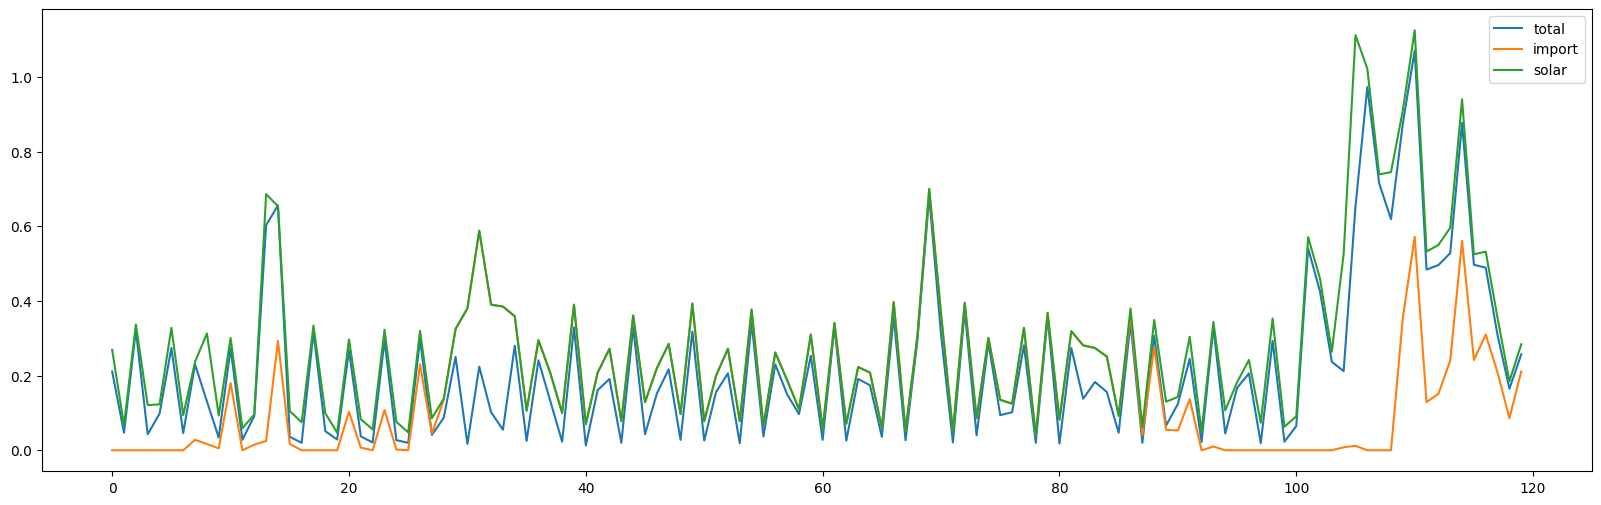

In [326]:
plt.figure(figsize=(20,6))

plt.plot(industrial_data['total_power_consumption_kwh'][00:120], label='total')
plt.plot(industrial_data['DE_KN_residential4_grid_import'][00:120], label='import')
# plt.plot(industrial_data['DE_KN_residential4_grid_export'][00:120], label='export')
# plt.plot(industrial_data['DE_KN_residential4_ev'][00:120], label='ev')
plt.plot((industrial_data['DE_KN_residential4_pv'][:120] - industrial_data['DE_KN_residential4_grid_export'][00:120]) + industrial_data['DE_KN_residential4_grid_import'][00:120], label='solar')

plt.legend()
plt.show()

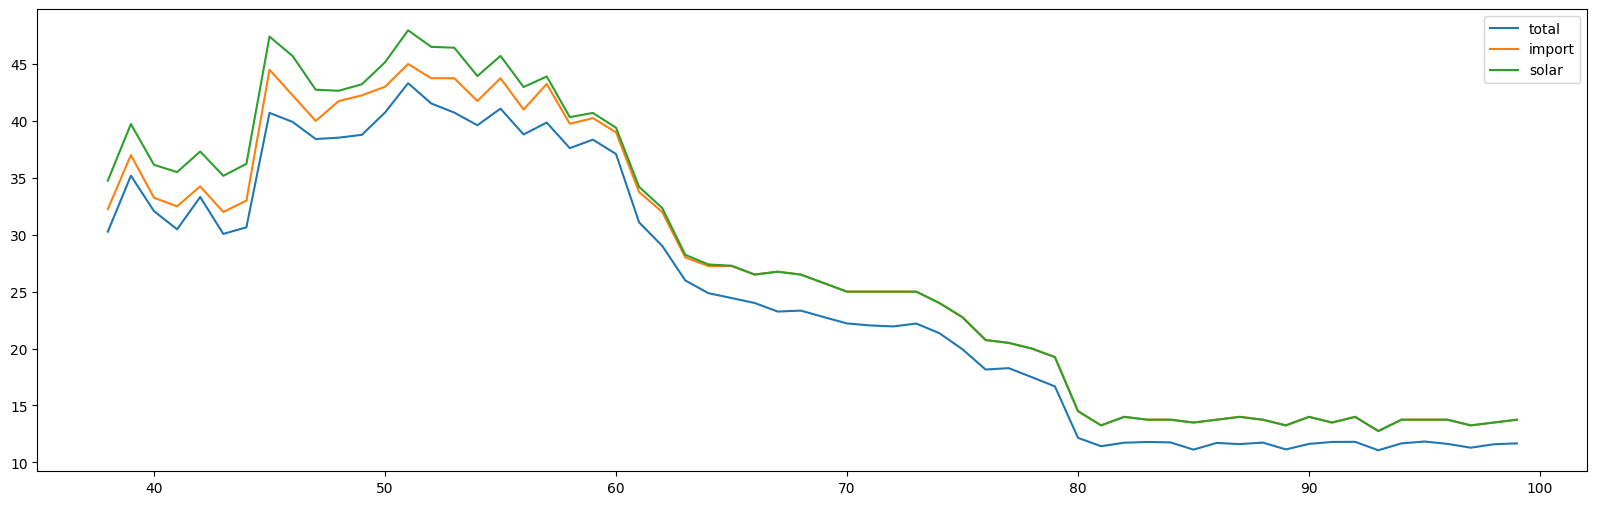

In [302]:
plt.figure(figsize=(20,6))

plt.plot(industrial_data['total_power_consumption_kwh'][38:100], label='total')
plt.plot(industrial_data['DE_KN_industrial3_grid_import'][38:100], label='import')
# plt.plot(industrial_data['DE_KN_residential4_grid_export'][00:120], label='export')
# plt.plot(industrial_data['DE_KN_residential4_ev'][00:120], label='ev')
plt.plot(industrial_data['DE_KN_industrial3_pv_facade'][38:100] + industrial_data['DE_KN_industrial3_pv_roof'][38:100] + industrial_data['DE_KN_industrial3_grid_import'][38:100], label='solar')

plt.legend()
plt.show()